In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="2"

Thu Aug 24 18:10:23 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.125.06   Driver Version: 525.125.06   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A5000    Off  | 00000000:1B:00.0 Off |                    0 |
| 30%   22C    P8    13W / 230W |      6MiB / 23028MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA RTX A5000    Off  | 00000000:1C:00.0 Off |                  Off |
| 30%   

### Hyperparams

In [3]:
n_mels = 1024
n_outputs = 61
n_frames = 400

### Model

In [4]:
from model.model_glowtts_sid import Model
from utils.util import *
from tensorboardX import SummaryWriter

step = 0
device = 'cuda:0'

# Model
model = Model(in_dim=n_mels, enc_hidden_dim=256, out_dim=61, dec_hidden_dim=256)
model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-5)
print('done')

done


### Load

In [5]:
save_dir = '/data/scpark/save/lips/train08.24-2/'
!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, model, _, optimizer = load(save_dir, 50421, model, None, optimizer)

total 646392
-rw-rw-r-- 1 scpark scpark       131  8월 24 18:09 events.out.tfevents.1692868021.GPUSVR01
-rw-rw-r-- 1 scpark scpark 661888901  8월 24 18:08 save_0
-rw-rw-r-- 1 scpark scpark       131  8월 24 18:01 events.out.tfevents.1692867562.GPUSVR01
-rw-rw-r-- 1 scpark scpark        40  8월 24 17:59 events.out.tfevents.1692867516.GPUSVR01


### Dataset

In [6]:
import os
from data.arkit_dataset import LipsDataset, CombinedDataset, CombinedCollate

root_dir = '/data/speech/digital_human/preprocessed/'

def get_files(dir):
    data = []
    files = sorted([os.path.join(dir, file) for file in os.listdir(dir)])
    for file in files:
        if file.endswith('.npy') and 'ARKit' in file:
            data.append(file)
        if os.path.isdir(file):
            data.extend(get_files(os.path.join(dir, file)))
    return data

files = get_files(root_dir)
print(len(files))

train_datasets = []
test_datasets = []

def get_sid(file):
    names = ['No Speaker', 'jeewonPark', 'jinwooOh', 'kyuchulLee', 'kyuseokKim', 'nohsikPark', 'soochulPark', 'yehunHwang']
    for sid, name in enumerate(names):
        if name in file:
            return sid
    return 0

for file in files:
    sid = get_sid(file)
    print(sid, file)
    dataset = LipsDataset(file, n_mels, n_frames, sid=sid, mel=False)
    if '_10_' in file:
        test_datasets.append(dataset)
    else:
        train_datasets.append(dataset)
print(len(train_datasets), len(test_datasets))

76
1 /data/speech/digital_human/preprocessed/jeewonPark/MH_ARKit_003_10_iPhone_raw.npy
1 /data/speech/digital_human/preprocessed/jeewonPark/MH_ARKit_003_11_iPhone_raw.npy
1 /data/speech/digital_human/preprocessed/jeewonPark/MH_ARKit_003_12_iPhone_raw.npy
1 /data/speech/digital_human/preprocessed/jeewonPark/MH_ARKit_003_1_iPhone_raw.npy
1 /data/speech/digital_human/preprocessed/jeewonPark/MH_ARKit_003_2_iPhone_raw.npy
1 /data/speech/digital_human/preprocessed/jeewonPark/MH_ARKit_003_3_iPhone_raw.npy
1 /data/speech/digital_human/preprocessed/jeewonPark/MH_ARKit_003_4_iPhone_raw.npy
1 /data/speech/digital_human/preprocessed/jeewonPark/MH_ARKit_003_5_iPhone_raw.npy
1 /data/speech/digital_human/preprocessed/jeewonPark/MH_ARKit_003_8_iPhone_raw.npy
1 /data/speech/digital_human/preprocessed/jeewonPark/MH_ARKit_003_9_iPhone_raw.npy
2 /data/speech/digital_human/preprocessed/jinwooOh/MH_ARKit_005_10_iPhone_raw.npy
2 /data/speech/digital_human/preprocessed/jinwooOh/MH_ARKit_005_1_iPhone_raw.npy
2

In [7]:
train_loader = torch.utils.data.DataLoader(CombinedDataset(train_datasets), 
                                           num_workers=8, shuffle=True, batch_size=16, collate_fn=CombinedCollate())
test_loader = torch.utils.data.DataLoader(CombinedDataset(test_datasets), 
                                          num_workers=10, shuffle=True, batch_size=10, collate_fn=CombinedCollate())
print('done')

done


In [8]:
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor

processor = Wav2Vec2Processor.from_pretrained("kresnik/wav2vec2-large-xlsr-korean")
wav2vec = Wav2Vec2ForCTC.from_pretrained("kresnik/wav2vec2-large-xlsr-korean").to(device)
print('done')

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


done


In [9]:
from torchaudio.transforms import Resample
resample = Resample(24000, 16000).to(device)

def get_states(wav, size, layer=24):
    # 24k to 16k
    wav = resample(wav)
    # Get probs.
    with torch.no_grad():
        states = wav2vec(wav, output_hidden_states=True).hidden_states[layer].transpose(1, 2)
    # Resizing
    states = F.interpolate(states, size=size, mode='linear').detach()
    return states


test : 0 1.046942114830017
test : 1 1.0483042001724243
test : 2 1.0581849813461304
test : 3 1.0537793636322021
test : 4 1.0546420812606812
test : 5 1.0494755506515503
test : 6 1.0589210987091064
test : 7 1.0409483909606934
test : 8 1.0453382730484009
test : 9 1.0410735607147217
test_loss : 1.0497610569000244


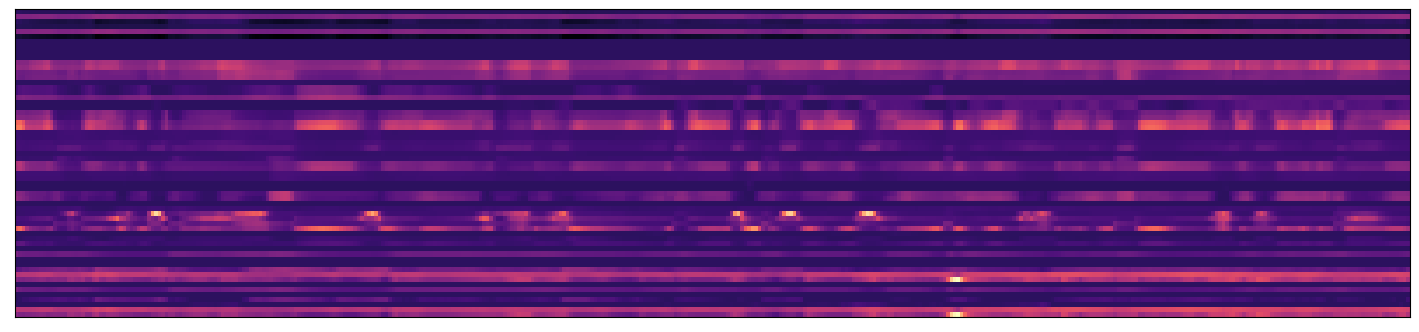

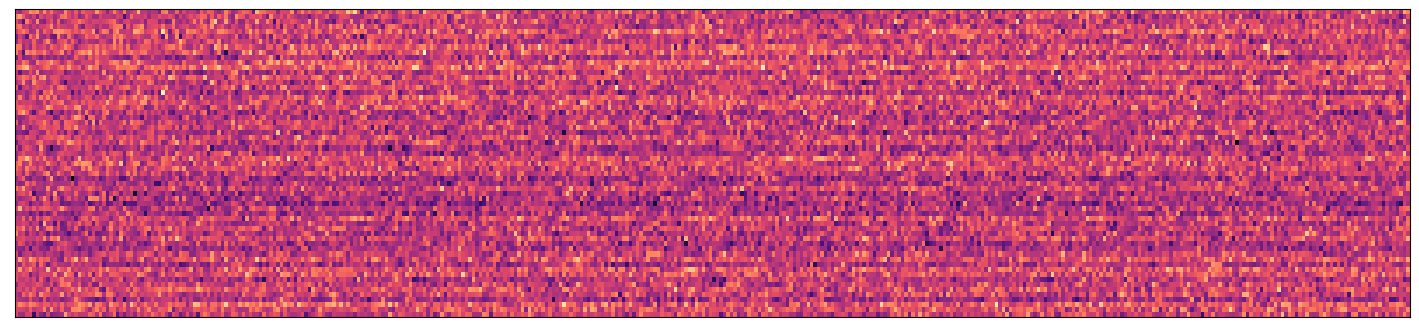

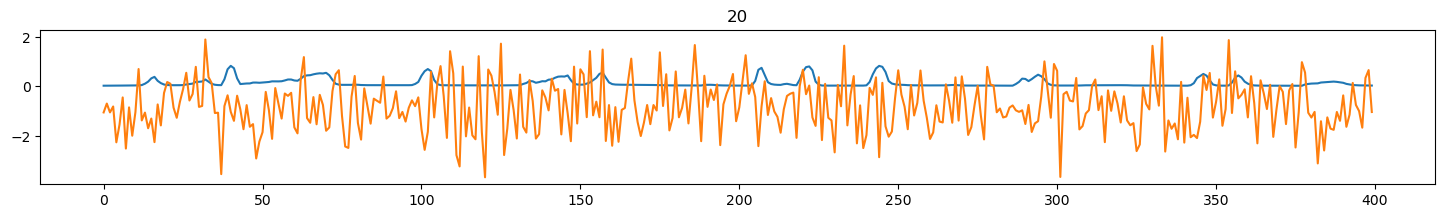

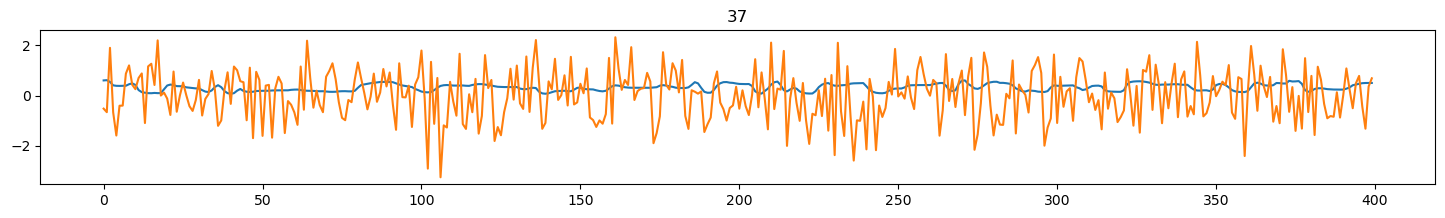

saved /data/scpark/save/lips/train08.24-2/save_0
1
loss 1.0652356147766113
1 1.0652356147766113
2
loss 0.9663671851158142
2 0.9663671851158142
3
loss 0.8741981983184814
3 0.8741981983184814
4
loss 0.7950172424316406
4 0.7950172424316406
5
loss 0.70191490650177
5 0.70191490650177
6
loss 0.631920576095581
6 0.631920576095581
7
loss 0.5808184146881104
7 0.5808184146881104
8
loss 0.48852986097335815
8 0.48852986097335815
9
loss 0.4492305815219879
9 0.4492305815219879
10
loss 0.393497109413147
10 0.393497109413147
11
loss 0.3357967138290405
11 0.3357967138290405
12
loss 0.28040170669555664
12 0.28040170669555664
13
loss 0.2526516914367676
13 0.2526516914367676
14
loss 0.19628453254699707
14 0.19628453254699707
15
loss 0.13636422157287598
15 0.13636422157287598
16
loss 0.11032360792160034
16 0.11032360792160034
17
loss 0.05458378791809082
17 0.05458378791809082
18
loss 0.00937807559967041
18 0.00937807559967041
19
loss -0.02412313222885132


In [ ]:
from IPython import display
import librosa.display
import matplotlib.pyplot as plt

isnan = False
while True:
    if isnan:
        break
    for batch in train_loader:
        targets = torch.Tensor(batch['blend']).transpose(1, 2).to(device)
        inputs = get_states(torch.Tensor(batch['wav']).to(device), targets.shape[-1])
        sid = torch.Tensor(batch['sid']).int().to(device)
        
        model.train()
        model.zero_grad()
        outputs = model(inputs, targets, sid)
        
        print(step)
        loss = 0
        for key in outputs.keys():
            if 'loss' in key:
                loss += outputs[key]
                print(key, outputs[key].item())
        if torch.isnan(loss):
            isnan = True
            break
        loss.backward()
        optimizer.step()
        print(step, loss.item())
        
        if step % 1000 == 0:
            writer.add_scalar('train_loss', loss.item(), step)
        
        if step % 1000 == 0:
            display.clear_output()
            
            losses = []
            for i, batch in enumerate(test_loader):
                if i >= 10:
                    break
                    
                targets = torch.Tensor(batch['blend']).transpose(1, 2).to(device)
                inputs = get_states(torch.Tensor(batch['wav']).to(device), targets.shape[-1])
                sid = torch.Tensor(batch['sid']).int().to(device)

                model.eval()
                with torch.no_grad():
                    outputs = model(inputs, targets, sid)
                    
                loss = 0
                for key in outputs.keys():
                    if 'loss' in key:
                        loss += outputs[key]
                print('test :', i, loss.item())
                losses.append(loss)        
            
            test_loss = torch.stack(losses).mean().item()
            print('test_loss :', test_loss)
            writer.add_scalar('test_loss', test_loss, step)
            
            plt.figure(figsize=[18, 4])
            librosa.display.specshow(targets[0].data.cpu().numpy(), cmap='magma')
            plt.show()

            model.eval()
            with torch.no_grad():
                y_pred = model.inference(inputs, sid)

            plt.figure(figsize=[18, 4])
            librosa.display.specshow(y_pred[0].data.cpu().numpy(), cmap='magma')
            plt.show()
            
            for i in [20, 37]:
                plt.figure(figsize=[18, 2])
                plt.title(str(i))
                plt.plot(targets[0].data.cpu().numpy()[i])
                plt.plot(y_pred[0].data.cpu().numpy()[i])
                plt.show()

        if step % 10000 == 0:
            save(save_dir, step, model, None, optimizer)
    
        step += 1

In [ ]:
save(save_dir, step, model, None, optimizer)

In [ ]:
print('done')